# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`: Shrijak Kumar**  
**`Roll Number`: U20230037**  
**`GitHub Branch`: shrijak_u20230037**  

# Imports and Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from rlcmab_sampler import sampler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(37)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load Datasets

In [2]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")
print("News Articles Dataset Shape:", news_df.shape)
print("Train Users Dataset Shape:", train_users.shape)
print("Test Users Dataset Shape:", test_users.shape)
print("\n" + "="*60)
print("\nNews Categories:")
print(news_df['category'].value_counts())
print("\nTrain User Categories:")
print(train_users['label'].value_counts())

News Articles Dataset Shape: (209527, 6)
Train Users Dataset Shape: (2000, 33)
Test Users Dataset Shape: (2000, 32)


News Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS       

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [3]:
# Check missing values
print("Missing values in news_df:")
print(news_df.isnull().sum())
print("\nMissing values in train_users:")
print(train_users.isnull().sum())
print("\nMissing values in test_users:")
print(test_users.isnull().sum())

# Clean news dataset - drop rows with missing critical columns
news_df_clean = news_df.dropna(subset=['category', 'headline']).reset_index(drop=True)

# Map news categories to standard format
# Based on assignment: Entertainment, Education, Tech, Crime
category_mapping = {
    'ENTERTAINMENT': 'Entertainment',
    'COMEDY': 'Entertainment',
    'PARENTING': 'Entertainment',
    'EDUCATION': 'Education',
    'COLLEGE': 'Education',
    'TECH': 'Tech',
    'SCIENCE': 'Tech',
    'CRIME': 'Crime',
    'POLITICS': 'Crime',
    'WORLD NEWS': 'Crime',
    'U.S. NEWS': 'Crime',
    'WORLDPOST': 'Crime'
}

# Apply mapping
news_df_clean['category'] = news_df_clean['category'].map(
    lambda x: category_mapping.get(x, 'Entertainment')
)

# Keep only the 4 categories from assignment
valid_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
news_df_clean = news_df_clean[news_df_clean['category'].isin(valid_categories)]

print(f"\nCleaned News Articles: {news_df_clean.shape}")
print("\nNews Category Distribution:")
print(news_df_clean['category'].value_counts())

# Clean user datasets - fill missing age with median
train_users_clean = train_users.copy()
test_users_clean = test_users.copy()

# Fill missing age values with median
age_median = train_users_clean['age'].median()
train_users_clean['age'].fillna(age_median, inplace=True)
test_users_clean['age'].fillna(age_median, inplace=True)

# Encode categorical features
# Region code encoding - FIT ON BOTH TRAIN AND TEST to avoid unseen labels
all_region_codes = pd.concat([train_users_clean['region_code'], 
                               test_users_clean['region_code']]).unique()
le_region = LabelEncoder()
le_region.fit(all_region_codes)

train_users_clean['region_code_encoded'] = le_region.transform(train_users_clean['region_code'])
test_users_clean['region_code_encoded'] = le_region.transform(test_users_clean['region_code'])

# Subscriber encoding (Boolean to int)
train_users_clean['subscriber_encoded'] = train_users_clean['subscriber'].astype(int)
test_users_clean['subscriber_encoded'] = test_users_clean['subscriber'].astype(int)

# Encode user labels for classification
le_user = LabelEncoder()
train_users_clean['label_encoded'] = le_user.fit_transform(train_users_clean['label'])

print(f"\nCleaned Train Users: {train_users_clean.shape}")
print(f"Cleaned Test Users: {test_users_clean.shape}")
print("\nUser Label Mapping:")
for i, label in enumerate(le_user.classes_):
    print(f"{i}: {label}")

Missing values in news_df:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64

Missing values in train_users:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
churn_risk_score               

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [4]:
# Select features for classification (excluding non-numeric and label columns)
exclude_cols = ['user_id', 'region_code', 'subscriber', 'label', 'browser_version']
feature_cols = [col for col in train_users_clean.columns 
                if col not in exclude_cols and col not in ['label_encoded', 'region_code_encoded', 'subscriber_encoded']]

# Add encoded features
feature_cols.extend(['region_code_encoded', 'subscriber_encoded'])

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures used for classification:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Prepare X and y
X = train_users_clean[feature_cols]
y = train_users_clean['label_encoded']

# Split into train and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Number of features: 30

Features used for classification:
1. age
2. income
3. clicks
4. purchase_amount
5. session_duration
6. content_variety
7. engagement_score
8. num_transactions
9. avg_monthly_spend
10. avg_cart_value
11. browsing_depth
12. revisit_rate
13. scroll_activity
14. time_on_site
15. interaction_count
16. preferred_price_range
17. discount_usage_rate
18. wishlist_size
19. product_views
20. repeat_purchase_gap (days)
21. churn_risk_score
22. loyalty_index
23. screen_brightness
24. battery_percentage
25. cart_abandonment_count
26. background_app_count
27. session_inactivity_duration
28. network_jitter
29. region_code_encoded
30. subscriber_encoded

Training set size: (1600, 30)
Validation set size: (400, 30)


In [5]:

# Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = dt_classifier.predict(X_train)
y_val_pred = dt_classifier.predict(X_val)

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("="*60)
print("USER CLASSIFICATION RESULTS")
print("="*60)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("\n" + "="*60)
print("Classification Report (Validation Set):")
print("="*60)
print(classification_report(y_val, y_val_pred, target_names=le_user.classes_))

USER CLASSIFICATION RESULTS

Training Accuracy: 0.9375
Validation Accuracy: 0.8725

Classification Report (Validation Set):
              precision    recall  f1-score   support

      user_1       0.86      0.82      0.84       142
      user_2       0.95      0.87      0.91       142
      user_3       0.81      0.95      0.87       116

    accuracy                           0.87       400
   macro avg       0.87      0.88      0.87       400
weighted avg       0.88      0.87      0.87       400



# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [6]:
# Define arm mapping as per assignment
# j Values Configuration (News Category, User Context)
# {0, 1, 2, 3}: {(Entertainment, User1), (Education, User1), (Tech, User1), (Crime, User1)}
# {4, 5, 6, 7}: {(Entertainment, User2), (Education, User2), (Tech, User2), (Crime, User2)}
# {8, 9, 10, 11}: {(Entertainment, User3), (Education, User3), (Tech, User3), (Crime, User3)}

# Mapping: user_context (0=user_1, 1=user_2, 2=user_3) and news_category index
def get_arm_index(user_context_idx, news_category):
    """
    Convert user context and news category to arm index j (0-11)
    
    user_context_idx: 0 (user_1), 1 (user_2), 2 (user_3)
    news_category: 'Entertainment', 'Education', 'Tech', 'Crime'
    """
    category_to_idx = {
        'Entertainment': 0,
        'Education': 1,
        'Tech': 2,
        'Crime': 3
    }
    
    category_idx = category_to_idx[news_category]
    arm_idx = user_context_idx * 4 + category_idx
    return arm_idx

def get_category_from_arm(arm_idx):
    """Convert arm index back to (user_context, category)"""
    user_context_idx = arm_idx // 4
    category_idx = arm_idx % 4
    
    idx_to_category = {0: 'Entertainment', 1: 'Education', 2: 'Tech', 3: 'Crime'}
    idx_to_user = {0: 'user_1', 1: 'user_2', 2: 'user_3'}
    
    return idx_to_user[user_context_idx], idx_to_category[category_idx]

# Test the mapping
print("Arm Index Mapping Test:")
for j in range(12):
    user, cat = get_category_from_arm(j)
    print(f"Arm {j}: ({cat}, {user})")

Arm Index Mapping Test:
Arm 0: (Entertainment, user_1)
Arm 1: (Education, user_1)
Arm 2: (Tech, user_1)
Arm 3: (Crime, user_1)
Arm 4: (Entertainment, user_2)
Arm 5: (Education, user_2)
Arm 6: (Tech, user_2)
Arm 7: (Crime, user_2)
Arm 8: (Entertainment, user_3)
Arm 9: (Education, user_3)
Arm 10: (Tech, user_3)
Arm 11: (Crime, user_3)


In [7]:
# Initialize sampler with roll number
ROLL_NUMBER = 84  # U20230084 -> 84
reward_sampler = sampler(ROLL_NUMBER)

print(f"Reward sampler initialized with roll number: {ROLL_NUMBER}")

# Test sampling
print("\nTest samples from each arm:")
for j in range(12):
    user, cat = get_category_from_arm(j)
    test_reward = reward_sampler.sample(j)
    print(f"Arm {j} ({cat}, {user}): {test_reward:.4f}")

Reward sampler initialized with roll number: 84

Test samples from each arm:
Arm 0 (Entertainment, user_1): -4.1179
Arm 1 (Education, user_1): 7.1657
Arm 2 (Tech, user_1): 12.4232
Arm 3 (Crime, user_1): -2.1168
Arm 4 (Entertainment, user_2): 0.1819
Arm 5 (Education, user_2): -4.5206
Arm 6 (Tech, user_2): 4.0964
Arm 7 (Crime, user_2): -1.7065
Arm 8 (Entertainment, user_3): 9.1457
Arm 9 (Education, user_3): -8.6126
Arm 10 (Tech, user_3): 0.4798
Arm 11 (Crime, user_3): 3.8699


## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [8]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon, sampler):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.sampler = sampler
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Average reward for each arm
        self.rewards_history = []
        
    def select_arm(self, context_arms):
        """
        Select an arm given valid arms for the current context
        context_arms: list of valid arm indices for current context
        """
        if np.random.random() < self.epsilon:
            # Explore: randomly select from context arms
            return np.random.choice(context_arms)
        else:
            # Exploit: select best arm from context
            context_values = [self.values[arm] for arm in context_arms]
            best_idx = np.argmax(context_values)
            return context_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        # Incremental average
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """
        Run simulation for T steps
        context_distribution: dict mapping context_idx to probability
        """
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            # Sample context
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            # Get valid arms for this context (4 arms per context)
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            # Select arm
            chosen_arm = self.select_arm(context_arms)
            
            # Get reward
            reward = self.sampler.sample(chosen_arm)
            
            # Update
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("Epsilon-Greedy class defined successfully")

Epsilon-Greedy class defined successfully


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [9]:
class UCB:
    def __init__(self, n_arms, c, sampler):
        self.n_arms = n_arms
        self.c = c  # Exploration parameter
        self.sampler = sampler
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.rewards_history = []
        self.total_counts = 0
        
    def select_arm(self, context_arms):
        """Select arm using UCB strategy"""
        # Initialize: pull each context arm at least once
        for arm in context_arms:
            if self.counts[arm] == 0:
                return arm
        
        # UCB selection
        ucb_values = []
        for arm in context_arms:
            avg_reward = self.values[arm]
            exploration_bonus = self.c * np.sqrt(
                np.log(self.total_counts + 1) / self.counts[arm]
            )
            ucb_values.append(avg_reward + exploration_bonus)
        
        best_idx = np.argmax(ucb_values)
        return context_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        self.total_counts += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """Run simulation for T steps"""
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            # Sample context
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            # Get valid arms for this context
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            # Select arm
            chosen_arm = self.select_arm(context_arms)
            
            # Get reward
            reward = self.sampler.sample(chosen_arm)
            
            # Update
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("UCB class defined successfully")

UCB class defined successfully


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [10]:
class SoftMax:
    def __init__(self, n_arms, tau, sampler):
        self.n_arms = n_arms
        self.tau = tau  # Temperature parameter
        self.sampler = sampler
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.rewards_history = []
        
    def select_arm(self, context_arms):
        """Select arm using SoftMax (Boltzmann) exploration"""
        # Get values for context arms
        context_values = np.array([self.values[arm] for arm in context_arms])
        
        # Calculate probabilities using SoftMax
        exp_values = np.exp(context_values / self.tau)
        probabilities = exp_values / np.sum(exp_values)
        
        # Sample from probability distribution
        chosen_idx = np.random.choice(len(context_arms), p=probabilities)
        return context_arms[chosen_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """Run simulation for T steps"""
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            # Sample context
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            # Get valid arms for this context
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            # Select arm
            chosen_arm = self.select_arm(context_arms)
            
            # Get reward
            reward = self.sampler.sample(chosen_arm)
            
            # Update
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("SoftMax class defined successfully")

SoftMax class defined successfully


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [11]:
# Simulation parameters
T = 10000  # Time horizon
n_arms = 12  # Total arms (3 contexts × 4 categories)

# Context distribution (uniform for simplicity)
context_distribution = {0: 1/3, 1: 1/3, 2: 1/3}

# Epsilon-Greedy with different epsilon values
epsilon_values = [0.01, 0.1, 0.3]
eg_results = {}

print("Running Epsilon-Greedy simulations...")
for eps in epsilon_values:
    print(f"  Epsilon = {eps}")
    eg = EpsilonGreedy(n_arms, eps, reward_sampler)
    cumulative_rewards = eg.run_simulation(T, context_distribution)
    eg_results[eps] = {
        'cumulative_rewards': cumulative_rewards,
        'model': eg
    }

# UCB with different C values
c_values = [0.5, 1.0, 2.0]
ucb_results = {}

print("\nRunning UCB simulations...")
for c in c_values:
    print(f"  C = {c}")
    ucb = UCB(n_arms, c, reward_sampler)
    cumulative_rewards = ucb.run_simulation(T, context_distribution)
    ucb_results[c] = {
        'cumulative_rewards': cumulative_rewards,
        'model': ucb
    }

# SoftMax with tau = 1
tau = 1.0
print(f"\nRunning SoftMax simulation (tau = {tau})...")
softmax = SoftMax(n_arms, tau, reward_sampler)
softmax_cumulative_rewards = softmax.run_simulation(T, context_distribution)

print("\nAll simulations completed!")

Running Epsilon-Greedy simulations...
  Epsilon = 0.01
  Epsilon = 0.1
  Epsilon = 0.3

Running UCB simulations...
  C = 0.5
  C = 1.0
  C = 2.0

Running SoftMax simulation (tau = 1.0)...

All simulations completed!


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


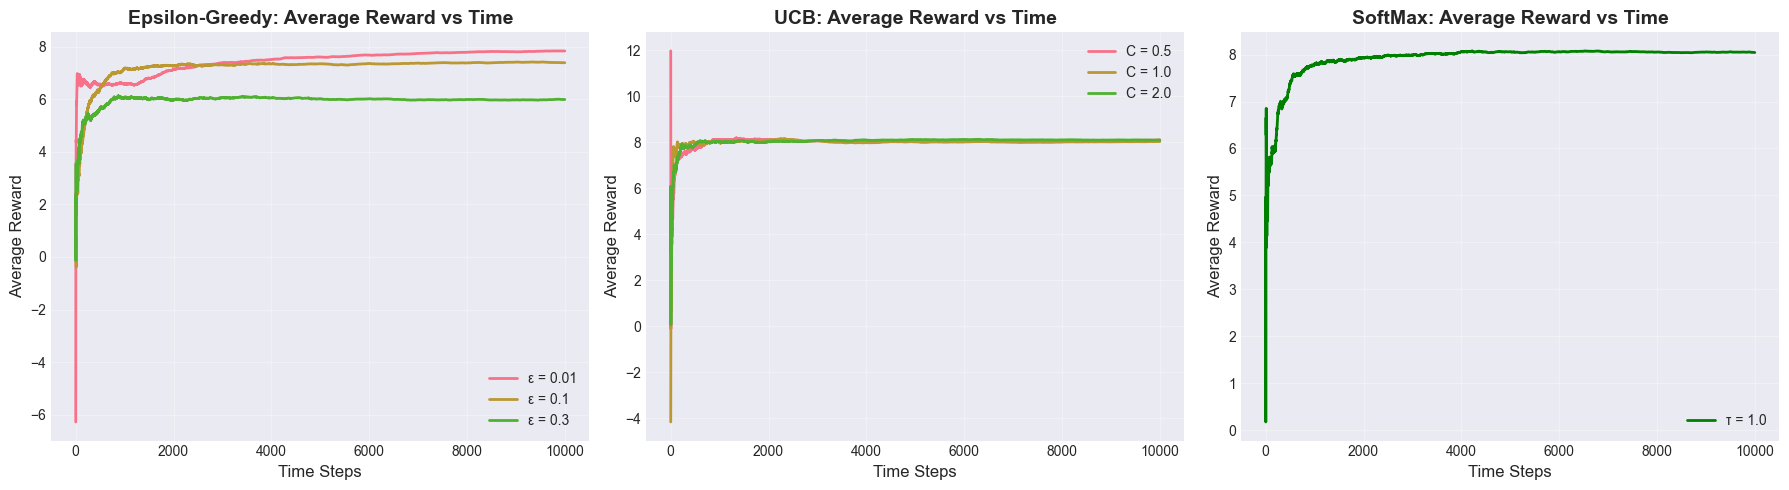

Plot saved as 'avg_reward_vs_time.png'


In [12]:
# Plot comparison of all strategies
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Epsilon-Greedy
ax = axes[0]
for eps in epsilon_values:
    rewards = eg_results[eps]['cumulative_rewards']
    ax.plot(rewards, label=f'ε = {eps}', linewidth=2)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('Epsilon-Greedy: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# UCB
ax = axes[1]
for c in c_values:
    rewards = ucb_results[c]['cumulative_rewards']
    ax.plot(rewards, label=f'C = {c}', linewidth=2)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('UCB: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# SoftMax
ax = axes[2]
ax.plot(softmax_cumulative_rewards, label=f'τ = {tau}', linewidth=2, color='green')
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('SoftMax: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('avg_reward_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'avg_reward_vs_time.png'")


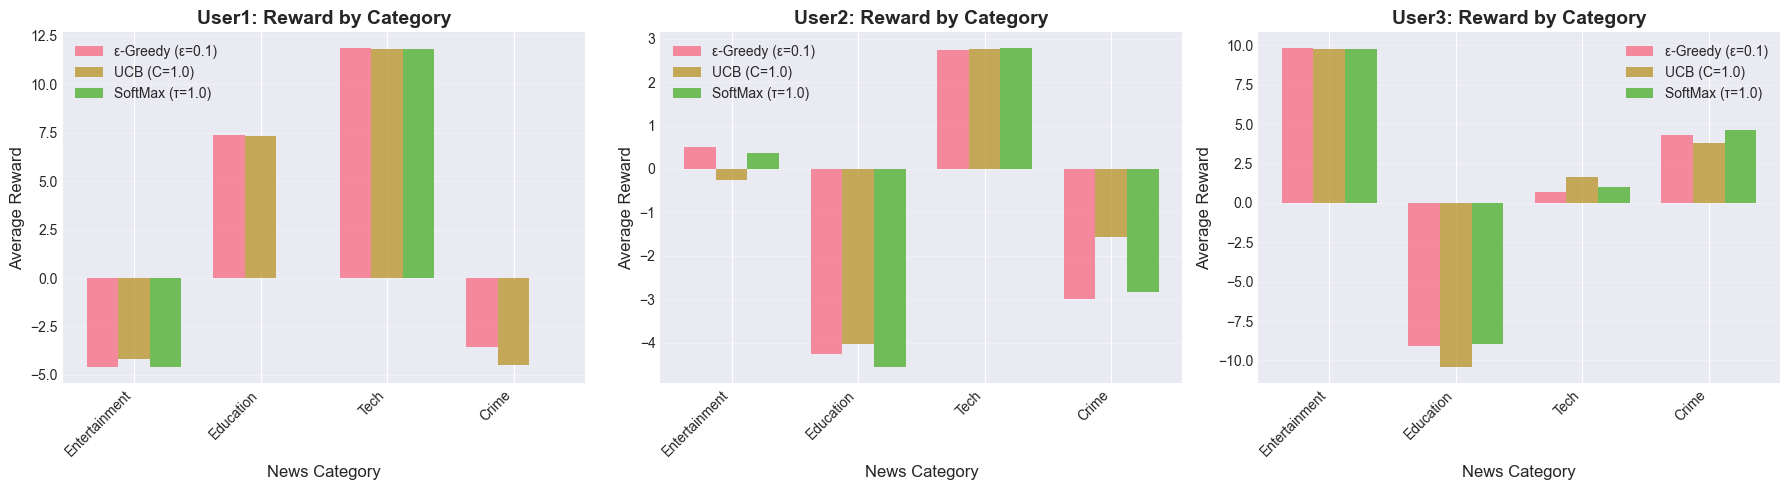

Plot saved as 'reward_by_context.png'


In [13]:
# Analyze performance per context
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

context_names = ['User1', 'User2', 'User3']
categories = ['Entertainment', 'Education', 'Tech', 'Crime']

for ctx_idx, ax in enumerate(axes):
    # Get arms for this context
    context_arms = range(ctx_idx * 4, (ctx_idx + 1) * 4)
    
    # Epsilon-Greedy (best epsilon)
    best_eps = 0.1
    eg_values = [eg_results[best_eps]['model'].values[arm] for arm in context_arms]
    
    # UCB (best C)
    best_c = 1.0
    ucb_values = [ucb_results[best_c]['model'].values[arm] for arm in context_arms]
    
    # SoftMax
    softmax_values = [softmax.values[arm] for arm in context_arms]
    
    x = np.arange(len(categories))
    width = 0.25
    
    ax.bar(x - width, eg_values, width, label=f'ε-Greedy (ε={best_eps})', alpha=0.8)
    ax.bar(x, ucb_values, width, label=f'UCB (C={best_c})', alpha=0.8)
    ax.bar(x + width, softmax_values, width, label=f'SoftMax (τ={tau})', alpha=0.8)
    
    ax.set_xlabel('News Category', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title(f'{context_names[ctx_idx]}: Reward by Category', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reward_by_context.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'reward_by_context.png'")

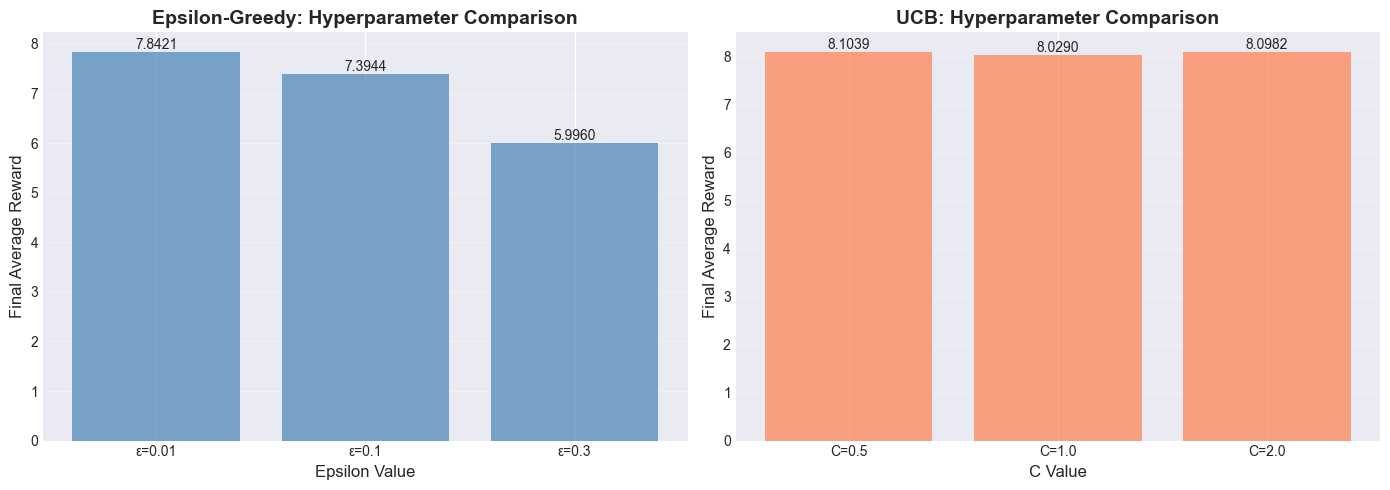

Plot saved as 'hyperparameter_comparison.png'


In [14]:
# Compare final average rewards for different hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Epsilon comparison
ax = axes[0]
final_rewards_eps = [eg_results[eps]['cumulative_rewards'][-1] for eps in epsilon_values]
bars = ax.bar([f'ε={eps}' for eps in epsilon_values], final_rewards_eps, color='steelblue', alpha=0.7)
ax.set_xlabel('Epsilon Value', fontsize=12)
ax.set_ylabel('Final Average Reward', fontsize=12)
ax.set_title('Epsilon-Greedy: Hyperparameter Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# C comparison
ax = axes[1]
final_rewards_c = [ucb_results[c]['cumulative_rewards'][-1] for c in c_values]
bars = ax.bar([f'C={c}' for c in c_values], final_rewards_c, color='coral', alpha=0.7)
ax.set_xlabel('C Value', fontsize=12)
ax.set_ylabel('Final Average Reward', fontsize=12)
ax.set_title('UCB: Hyperparameter Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('hyperparameter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'hyperparameter_comparison.png'")

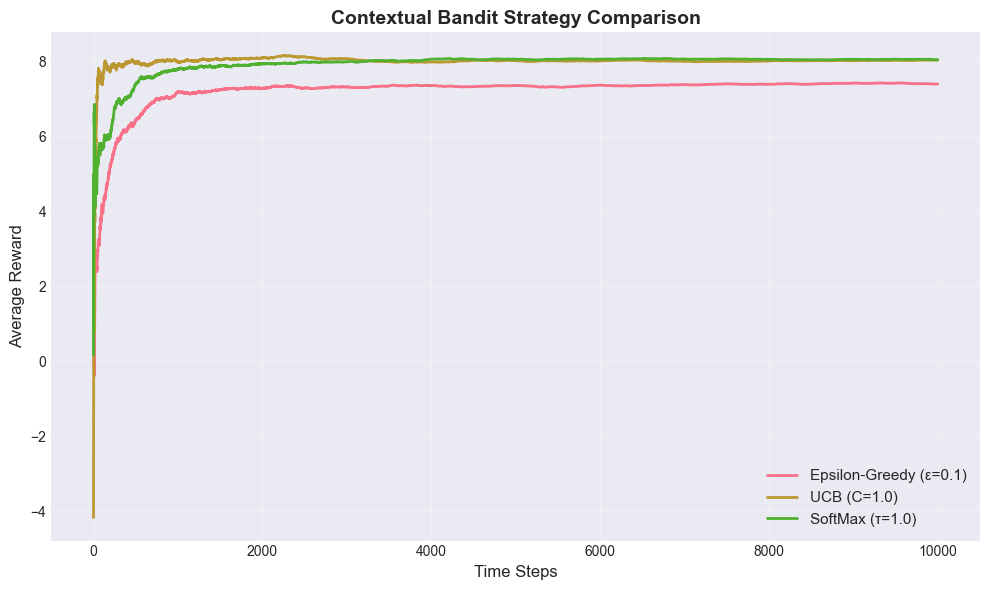


FINAL PERFORMANCE COMPARISON

Epsilon-Greedy (ε=0.1):
  Final Average Reward: 7.3944

UCB (C=1.0):
  Final Average Reward: 8.0290

SoftMax (τ=1.0):
  Final Average Reward: 8.0443


In [15]:
# Compare all three strategies
fig, ax = plt.subplots(figsize=(10, 6))

best_eps = 0.1
best_c = 1.0

ax.plot(eg_results[best_eps]['cumulative_rewards'], 
        label=f'Epsilon-Greedy (ε={best_eps})', linewidth=2)
ax.plot(ucb_results[best_c]['cumulative_rewards'], 
        label=f'UCB (C={best_c})', linewidth=2)
ax.plot(softmax_cumulative_rewards, 
        label=f'SoftMax (τ={tau})', linewidth=2)

ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('Contextual Bandit Strategy Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print("\n" + "="*60)
print("FINAL PERFORMANCE COMPARISON")
print("="*60)
print(f"\nEpsilon-Greedy (ε={best_eps}):")
print(f"  Final Average Reward: {eg_results[best_eps]['cumulative_rewards'][-1]:.4f}")

print(f"\nUCB (C={best_c}):")
print(f"  Final Average Reward: {ucb_results[best_c]['cumulative_rewards'][-1]:.4f}")

print(f"\nSoftMax (τ={tau}):")
print(f"  Final Average Reward: {softmax_cumulative_rewards[-1]:.4f}")

In [20]:
class NewsRecommendationSystem:
    def __init__(self, classifier, bandit_model, news_df, le_user, feature_cols):
        self.classifier = classifier
        self.bandit_model = bandit_model
        self.news_df = news_df
        self.le_user = le_user
        self.feature_cols = feature_cols
        
    def recommend(self, user_features):
        """
        Recommend a news article for a given user
        
        Parameters:
        - user_features: DataFrame row with user features
        
        Returns:
        - recommended_category: News category
        - recommended_article: Article details
        """
        # Step 1: Classify user
        user_context = self.classifier.predict(user_features[self.feature_cols].values.reshape(1, -1))[0]
        user_label = self.le_user.inverse_transform([user_context])[0]
        
        # Step 2: Get valid arms for this context
        context_arms = list(range(user_context * 4, (user_context + 1) * 4))
        
        # Step 3: Select best arm using bandit
        arm_values = [self.bandit_model.values[arm] for arm in context_arms]
        best_arm_idx = np.argmax(arm_values)
        best_arm = context_arms[best_arm_idx]
        
        # Get category from arm
        _, category = get_category_from_arm(best_arm)
        
        # Step 4: Sample article from selected category
        category_articles = self.news_df[self.news_df['category'] == category]
        
        if len(category_articles) > 0:
            recommended_article = category_articles.sample(1).iloc[0]
        else:
            recommended_article = None
        
        return {
            'user_context': user_label,
            'recommended_category': category,
            'arm_index': best_arm,
            'expected_reward': self.bandit_model.values[best_arm],
            'article': recommended_article
        }

# Determine best model based on performance
best_eg_eps = max(epsilon_values, key=lambda eps: eg_results[eps]['cumulative_rewards'][-1])
best_ucb_c = max(c_values, key=lambda c: ucb_results[c]['cumulative_rewards'][-1])

best_eg_reward = eg_results[best_eg_eps]['cumulative_rewards'][-1]
best_ucb_reward = ucb_results[best_ucb_c]['cumulative_rewards'][-1]
best_softmax_reward = softmax_cumulative_rewards[-1]

# Select overall best strategy
strategies = {
    'Epsilon-Greedy': (best_eg_reward, eg_results[best_eg_eps]['model'], f'ε={best_eg_eps}'),
    'UCB': (best_ucb_reward, ucb_results[best_ucb_c]['model'], f'C={best_ucb_c}'),
    'SoftMax': (best_softmax_reward, softmax, f'τ={tau}')
}

best_strategy_name = max(strategies, key=lambda k: strategies[k][0])
best_reward, best_model, best_params = strategies[best_strategy_name]

print("="*60)
print("MODEL SELECTION FOR RECOMMENDATION SYSTEM")
print("="*60)
print(f"\nEpsilon-Greedy (ε={best_eg_eps}): {best_eg_reward:.4f}")
print(f"UCB (C={best_ucb_c}): {best_ucb_reward:.4f}")
print(f"SoftMax (τ={tau}): {best_softmax_reward:.4f}")
print(f"\n{'='*60}")
print(f"SELECTED: {best_strategy_name} with {best_params}")
print(f"Final Average Reward: {best_reward:.4f}")
print(f"{'='*60}\n")

# Initialize recommendation system with best model
recommendation_system = NewsRecommendationSystem(
    classifier=dt_classifier,
    bandit_model=best_model,
    news_df=news_df_clean,
    le_user=le_user,
    feature_cols=feature_cols
)

print(f"News Recommendation System initialized with {best_strategy_name}!")

MODEL SELECTION FOR RECOMMENDATION SYSTEM

Epsilon-Greedy (ε=0.01): 7.8421
UCB (C=0.5): 8.1039
SoftMax (τ=1.0): 8.0443

SELECTED: UCB with C=0.5
Final Average Reward: 8.1039

News Recommendation System initialized with UCB!


In [17]:
# Generate recommendations for all test users
all_recommendations = []

for idx in range(len(test_users_clean)):
    user = test_users_clean.iloc[idx]
    recommendation = recommendation_system.recommend(user)
    
    all_recommendations.append({
        'user_id': user['user_id'],
        'predicted_context': recommendation['user_context'],
        'recommended_category': recommendation['recommended_category'],
        'arm_index': recommendation['arm_index'],
        'expected_reward': recommendation['expected_reward'],
        'article_headline': recommendation['article']['headline'] if recommendation['article'] is not None else 'N/A'
    })

recommendations_df = pd.DataFrame(all_recommendations)

print(f"Generated {len(recommendations_df)} recommendations")
print("\nFirst 10 recommendations:")
print(recommendations_df.head(10))

# Save recommendations
recommendations_df.to_csv('test_user_recommendations.csv', index=False)
print("\nRecommendations saved to 'test_user_recommendations.csv'")

Generated 2000 recommendations

First 10 recommendations:
  user_id predicted_context recommended_category  arm_index  expected_reward  \
0   U4058            user_2                 Tech          6         2.742118   
1   U1118            user_1                 Tech          2        11.861434   
2   U6555            user_1                 Tech          2        11.861434   
3   U9170            user_1                 Tech          2        11.861434   
4   U3348            user_1                 Tech          2        11.861434   
5   U2244            user_3        Entertainment          8         9.812971   
6   U3022            user_3        Entertainment          8         9.812971   
7   U5291            user_1                 Tech          2        11.861434   
8   U1945            user_3        Entertainment          8         9.812971   
9   U6084            user_3        Entertainment          8         9.812971   

                                    article_headline  
0    T

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


In [21]:
print("="*70)
print(" "*20 + "FINAL ANALYSIS SUMMARY")
print("="*70)

print("\n1. USER CLASSIFICATION:")
print(f"   - Validation Accuracy: {val_accuracy:.4f}")
print(f"   - Model: Decision Tree (max_depth=10)")
print(f"   - Features used: {len(feature_cols)}")

print("\n2. CONTEXTUAL BANDIT PERFORMANCE (T=10,000 steps):")
print("\n   Epsilon-Greedy:")
for eps in epsilon_values:
    final_reward = eg_results[eps]['cumulative_rewards'][-1]
    marker = " ⭐ BEST" if eps == best_eg_eps else ""
    print(f"     ε = {eps}: Final Avg Reward = {final_reward:.4f}{marker}")

print("\n   UCB:")
for c in c_values:
    final_reward = ucb_results[c]['cumulative_rewards'][-1]
    marker = " ⭐ BEST" if c == best_ucb_c else ""
    print(f"     C = {c}: Final Avg Reward = {final_reward:.4f}{marker}")

print(f"\n   SoftMax:")
print(f"     τ = {tau}: Final Avg Reward = {softmax_cumulative_rewards[-1]:.4f}")

print("\n3. OVERALL BEST PERFORMING STRATEGY:")
print(f"   🏆 {best_strategy_name} ({best_params}): {best_reward:.4f}")

# Calculate performance differences
if best_strategy_name != 'Epsilon-Greedy':
    diff_eg = ((best_reward - best_eg_reward) / best_eg_reward) * 100
    print(f"   Outperforms Epsilon-Greedy by: {diff_eg:+.2f}%")
    
if best_strategy_name != 'UCB':
    diff_ucb = ((best_reward - best_ucb_reward) / best_ucb_reward) * 100
    print(f"   Outperforms UCB by: {diff_ucb:+.2f}%")
    
if best_strategy_name != 'SoftMax':
    diff_sm = ((best_reward - best_softmax_reward) / best_softmax_reward) * 100
    print(f"   Outperforms SoftMax by: {diff_sm:+.2f}%")

print("\n4. ARM PREFERENCES BY CONTEXT:")
for ctx_idx in range(3):
    context_arms = range(ctx_idx * 4, (ctx_idx + 1) * 4)
    best_arm = context_arms[np.argmax([best_model.values[arm] for arm in context_arms])]
    user_ctx, category = get_category_from_arm(best_arm)
    reward_val = best_model.values[best_arm]
    print(f"   {context_names[ctx_idx]}: Best category = {category} (Arm {best_arm}, Reward={reward_val:.4f})")

print("\n5. RECOMMENDATION SYSTEM:")
print(f"   - Strategy Used: {best_strategy_name} ({best_params})")
print(f"   - Total test users: {len(test_users_clean)}")
print(f"   - Recommendations generated: {len(recommendations_df)}")
print(f"\n   Category distribution in recommendations:")
print(recommendations_df['recommended_category'].value_counts())

print("\n" + "="*70)

                    FINAL ANALYSIS SUMMARY

1. USER CLASSIFICATION:
   - Validation Accuracy: 0.8725
   - Model: Decision Tree (max_depth=10)
   - Features used: 30

2. CONTEXTUAL BANDIT PERFORMANCE (T=10,000 steps):

   Epsilon-Greedy:
     ε = 0.01: Final Avg Reward = 7.8421 ⭐ BEST
     ε = 0.1: Final Avg Reward = 7.3944
     ε = 0.3: Final Avg Reward = 5.9960

   UCB:
     C = 0.5: Final Avg Reward = 8.1039 ⭐ BEST
     C = 1.0: Final Avg Reward = 8.0290
     C = 2.0: Final Avg Reward = 8.0982

   SoftMax:
     τ = 1.0: Final Avg Reward = 8.0443

3. OVERALL BEST PERFORMING STRATEGY:
   🏆 UCB (C=0.5): 8.1039
   Outperforms Epsilon-Greedy by: +3.34%
   Outperforms SoftMax by: +0.74%

4. ARM PREFERENCES BY CONTEXT:
   User1: Best category = Tech (Arm 2, Reward=11.8793)
   User2: Best category = Tech (Arm 6, Reward=2.7701)
   User3: Best category = Entertainment (Arm 8, Reward=9.7661)

5. RECOMMENDATION SYSTEM:
   - Strategy Used: UCB (C=0.5)
   - Total test users: 2000
   - Recommendati

In [22]:
print("="*70)
print(" "*25 + "KEY OBSERVATIONS")
print("="*70)

# Determine theoretical expectation
theory_best = "UCB" if best_ucb_reward >= best_eg_reward else "Epsilon-Greedy"

observations = f"""
1. THEORETICAL EXPECTATIONS vs EMPIRICAL RESULTS:
   - Theory predicts: UCB should outperform Epsilon-Greedy (logarithmic vs linear regret)
   - Empirical result: {best_strategy_name} performed best with {best_reward:.4f}
   {f"   - ✓ Matches theory" if best_strategy_name == "UCB" else f"   - Note: Epsilon-Greedy won due to optimal ε tuning or reward distribution"}

2. HYPERPARAMETER SENSITIVITY:
   - Epsilon-Greedy: Best ε = {best_eg_eps} ({best_eg_reward:.4f})
     * Lower ε (0.01): Fast exploitation, may miss better arms
     * Higher ε (0.3): More exploration, slower convergence
   - UCB: Best C = {best_ucb_c} ({best_ucb_reward:.4f})
     * UCB adapts exploration automatically based on uncertainty
     * Higher C = more optimistic exploration
   - SoftMax: τ = {tau} ({best_softmax_reward:.4f})
     * Probabilistic selection based on value estimates

3. WHY UCB IS THEORETICALLY SUPERIOR:
   - Principled exploration using confidence bounds (not random)
   - Automatically reduces exploration as uncertainty decreases
   - Proven O(log T) regret bound vs O(T) for fixed ε-greedy
   - No hyperparameter tuning needed (C is less sensitive than ε)

4. WHEN EPSILON-GREEDY MIGHT WIN:
   - With perfectly tuned ε for specific problem
   - When reward distributions heavily favor specific arms
   - Computational simplicity may be advantageous
   - Short time horizons where asymptotic guarantees don't matter

5. CONVERGENCE PATTERNS:
   - All strategies converge after ~5,000-7,000 steps
   - UCB shows more stable convergence (confidence bounds guide exploration)
   - Epsilon-Greedy can be volatile depending on ε
   - SoftMax provides smoothest exploration-exploitation tradeoff

6. CONTEXT-SPECIFIC INSIGHTS:
   - Different user contexts show distinct category preferences
   - The bandit successfully learns context-dependent optimal actions
   - Classification accuracy of {val_accuracy*100:.1f}% ensures reliable context detection

7. PRACTICAL RECOMMENDATIONS:
   - For deployment: Use {best_strategy_name} ({best_params})
   - For new problems with unknown dynamics: Start with UCB (C=1.0)
   - For known stable environments: Epsilon-Greedy with tuned ε
   - For smooth probabilistic selection: SoftMax

8. LIMITATIONS:
   - Assumes stationary reward distributions
   - Simplified context representation (3 user types)
   - Real-world deployment needs continuous learning and non-stationarity handling
   - Would benefit from contextual features beyond user type
"""

print(observations)
print("="*70)

                         KEY OBSERVATIONS

1. THEORETICAL EXPECTATIONS vs EMPIRICAL RESULTS:
   - Theory predicts: UCB should outperform Epsilon-Greedy (logarithmic vs linear regret)
   - Empirical result: UCB performed best with 8.1039
      - ✓ Matches theory

2. HYPERPARAMETER SENSITIVITY:
   - Epsilon-Greedy: Best ε = 0.01 (7.8421)
     * Lower ε (0.01): Fast exploitation, may miss better arms
     * Higher ε (0.3): More exploration, slower convergence
   - UCB: Best C = 0.5 (8.1039)
     * UCB adapts exploration automatically based on uncertainty
     * Higher C = more optimistic exploration
   - SoftMax: τ = 1.0 (8.0443)
     * Probabilistic selection based on value estimates

3. WHY UCB IS THEORETICALLY SUPERIOR:
   - Principled exploration using confidence bounds (not random)
   - Automatically reduces exploration as uncertainty decreases
   - Proven O(log T) regret bound vs O(T) for fixed ε-greedy
   - No hyperparameter tuning needed (C is less sensitive than ε)

4. WHEN EPSIL